---
layout:     post
title:      "Dollars to doughnuts"
subtitle: "analyzing my food spending"
date:       2017-04-06 12:00:00
author:     Andrew
header-img: img/posts/food_spending/peppers_bg.jpg
header-credit: https://unsplash.com/@mobography
tags:       programming dynamics sympy python
---

This is a quick post to do some visualization on some of my financial data.  I was interested in determining if some concious changes I had been making to my food spending habits had actually materialized into real savings.

Everyone's always looking to find a place to save a few dimes, and over the past few months I've really started to take notice of my food spending.  After examining the last few months worth of budgets (I use mint to track my expenses and categorize them), I decided to make a concerted effort to eat out less, cook more and bring my lunch to work to reduce spending.

I started this effort roughly around mid February, but I'll look at the data starting at last October to give some historical trends.

Fine print:
* I was on vacation in the beginning of January, using cash only, so those transactions won't appear
* I didn't remove anomolies, like covering a meal for a group and getting paid in cash
* Some restaurants show up in Alcohol & Bars

I used my programming language of choice, [python](https://www.python.org/), with the [matplotlib](http://matplotlib.org/), [numpy](http://www.numpy.org/), and [scipy](https://www.scipy.org/) libraries.

This post will be interleaving the code and my rationale, so if you're not particularly interested in the code, you can skip over those sections.  I've done my best to make it a coherent article even without the code.

This first code block is just setting everything up and importing all the necessary libraries.

In [84]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import datetime, timedelta, date
from itertools import groupby, dropwhile, accumulate
from decimal import Decimal, getcontext
from pprint import pprint
from scipy import stats

%matplotlib inline

getcontext().prec = 6
preview_size = 5

mpl.rcParams['figure.figsize'] = (12.0, 10.0)
mpl.rcParams['font.size'] = 15

I use [mint](https://www.mint.com/) to track and categorize my finances.  It pulls transaction information from my bank accounts, and each month I run through the transactions from the previous month to make sure they were correctly categorized.

To start, I downloaded all my transactions from mint as a .csv (comma separated values) file. In excel, I removed everything except the columns for date, amount and category. I could have done some of that in python, but it was just easier to do it ahead of time.

Then in python, we can read in the file.  Python's `csv` module makes it easy to already separate the data.  The result is a list of all the rows.  Each row is already split up into the columns.

In [85]:
with open('transactions.csv','r') as transactions_csv:
    transactions = list(csv.reader(transactions_csv, delimiter=','))
    

pprint(transactions[:preview_size])

[['Date', 'Amount', 'Category'],
 ['4/06/2017', '1.34', 'Lunch at Work'],
 ['4/06/2017', '2.55', 'Lunch at Work'],
 ['4/05/2017', '7.22', 'Restaurants'],
 ['4/05/2017', '10.25', 'Movies & DVDs']]


The first step to make the data usable is to remove the column header text. `[1:]` takes everything except the first item in `transactions` (python indexing starts at `0`)

In [86]:
transactions = transactions[1:]

Right now, all the data is being stored as strings, which makes it difficult to do any kind of sorting or math.

To resolve this, let's make a new class (`Transaction`) to store this information.  This way, data types can also be assigned to the individual pieces of information their own data types.

The attributes of `Transaction` will be:
* `date`. `datetime.strptime` turns a string into an actual date object in python, so we can filter and sort by date.
* `amount` will be stored as `Decimal` (don't use floating point for currencies![^floating_bitcoin])
* `category` will remain a string.

Additionally, I'll add a `__str__` method to make things look nice when they get printed out.

In [87]:
class Transaction(object):
    
    def __init__(self, date, amount, category):
        self.date = datetime.strptime(date,"%m/%d/%Y")
        self.amount = Decimal(amount)
        self.category = category
    
    def __str__(self):
        return "${0:>6.2f} on {1:>8} ({2})".format(
            self.amount,
            self.date.strftime("%m/%d/%y"),
            self.category)
    
    def __repr__(self):
        return self.__str__()

In [88]:
transactions = [Transaction(date, amount, category) for date, amount, category in transactions]

In [89]:
pprint(transactions[:preview_size])

[$  1.34 on 04/06/17 (Lunch at Work),
 $  2.55 on 04/06/17 (Lunch at Work),
 $  7.22 on 04/05/17 (Restaurants),
 $ 10.25 on 04/05/17 (Movies & DVDs),
 $  1.18 on 04/06/17 (Lunch at Work)]


Our transaction list still contains every transaction from 2017 though, so we'll need to filter out the non-food related one.  Here is the list of the food categories that I track in mint.

In [90]:
food_categories = ['Alcohol & Bars',
'Coffee Shops',
'Fast Food',
'Groceries',
'Restaurants',
'Lunch at Work',
'Snacks']

transactions = [trans for trans in transactions if trans.category in food_categories]

Lastly, let's make sure the data is sorted (this is important later when we want to group the data).  This will sort the transactions first by date, then by category for transactions that happen on the same date.

In [91]:
transactions.sort(key = lambda trans: (trans.date, trans.category))

Next, let's trim our date range down to something recent.  I'll go from last October through today.

In [92]:
cutoff_date = datetime(day=1, month=10, year=2016)
transactions = [trans for trans in transactions if trans.date >= cutoff_date]

Now our data looks something like this:

In [93]:
pprint(transactions[:preview_size])

[$ 35.16 on 10/01/16 (Alcohol & Bars),
 $  9.92 on 10/01/16 (Alcohol & Bars),
 $  2.12 on 10/01/16 (Fast Food),
 $ 16.70 on 10/01/16 (Groceries),
 $  6.20 on 10/01/16 (Lunch at Work)]


`transactions` is now a list of all transactions, sorted by date.  The first thing we should look at is a simple bar graph of daily spending.  I anticipate that it won't be particularly information (might be very noisy), but it might spot if we've done something wrong to this point.

In order to do this, we first need to group the transactions by date.  Python has a function `groupby`, which does exactly this, but requires that the data be sorted (which we've already done).

Once the transactions are grouped by date, they're summed up and the dates and amounts are added to lists for plotting later.

In [94]:
grouped_transactions = groupby(transactions, key = lambda trans: trans.date)

dates = []
daily_sums = []

for date, transaction_group in grouped_transactions:
    dates.append(date)
    daily_sums.append(sum([trans.amount for trans in transaction_group]))

(This code is just to make pretty pictures)

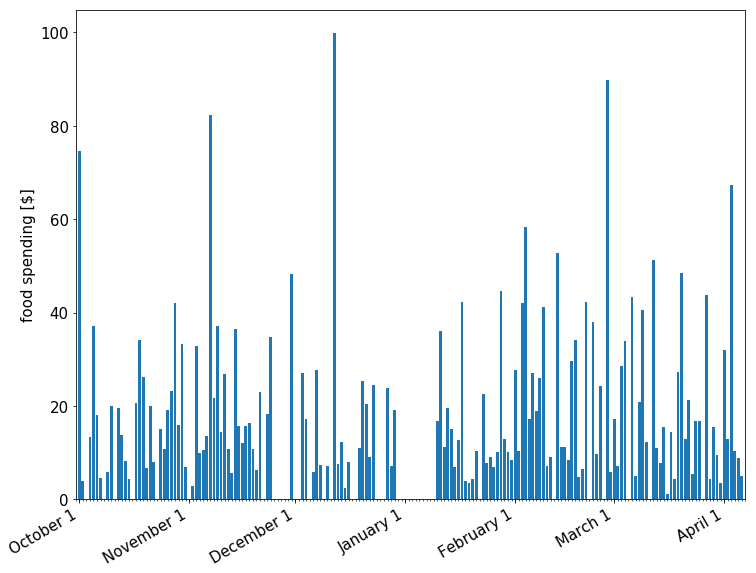

In [95]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()
monthFmt = mdates.DateFormatter('%B %-d')

fig, ax = plt.subplots(1)
plt.ylabel("food spending [$]")
fig.autofmt_xdate()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
ax.set_xlim([dates[0]-timedelta(days=1),dates[-1]+timedelta(days=1)])

ax.bar(dates, daily_sums)
plt.show()

The data looks plausible, but it's not particularly revealing.  With this fine of detail, it's hard to see any clear trends.  Let's try a [moving average](https://en.wikipedia.org/wiki/Moving_average) to see if that reveals any trends.

In this case, I'll be using a moving average to average my spending over the last `30` days.

First, I'm going to de

In [108]:
def calculate_rolling_window_sums(dates, daily_sums, time_frame):

    # index will be the date that we'll use to loop through our data
    # it starts n days from the beginning, which the first day that we
    # have enough data to average.  index is the end of our window
    # on each calculation
    start = dates[0]
    end = dates[-1]
    
    index = start + timedelta(days = time_frame-1)

    rolling = []
    rolling_dates = []
    
    # stop once we're within time_frame days of the end of the data
    while index <= end:

        # on each loop, filter out any transactions that don't fall in our window
        window = [trans for trans in transactions
                  if index - timedelta(days = time_frame) <= trans.date <= index]

        # sum all transactions that fall in the window
        # then average them
        # then add that average to our result
        rolling.append(sum([trans.amount for trans in window])/time_frame)

        # we're also keeping track of the dates for plotting later
        rolling_dates.append(index)

        #move the index date
        index = index + timedelta(days = 1)
        
    # return the date and sums lists
    return [rolling_dates, rolling]

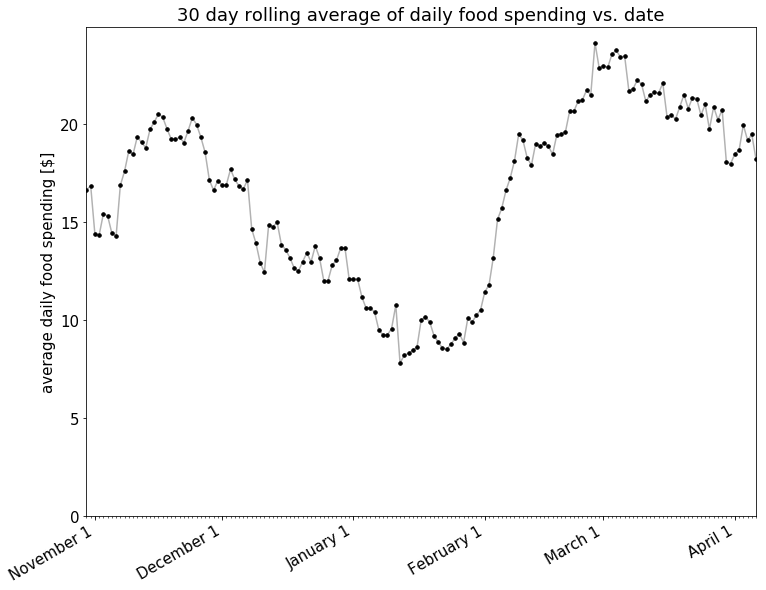

In [109]:
time_frame = 30

rolling_dates,rolling = calculate_rolling_window_sums(dates, daily_sums, time_frame)

fig, ax = plt.subplots(1)
ax.plot(rolling_dates,rolling,'k', alpha=0.3)
ax.plot(rolling_dates,rolling,'k.', markersize=7)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
fig.autofmt_xdate()
plt.ylabel("average daily food spending [$]")
ax.set_xlim([rolling_dates[0],rolling_dates[-1]])
ax.set_ylim(0)
ax.set_title("{} day rolling average of daily food spending vs. date".format(time_frame))

plt.show()

Nothing definitive at this point.  It's clear that my spending went up through February and March.  I do remember clearly being surprised at how much I was spending on food in February when I looked (which is what prompted my changes).

It also does appear that there is a decline in spending starting around March.  Let's look at the trend in 30 day moving average starting March 1st.

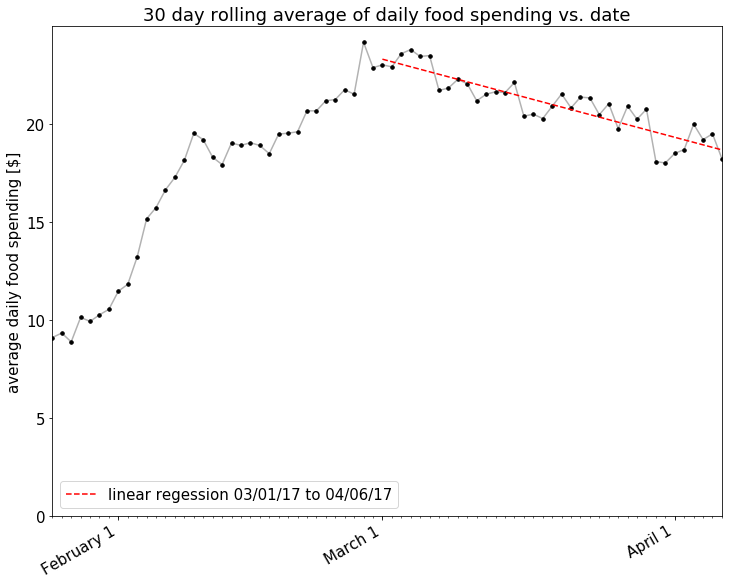

In [112]:
time_frame = 30

rolling_dates,rolling = calculate_rolling_window_sums(dates, daily_sums, time_frame)

linear_reg_start = datetime(day=1, month=3, year=2017)
linear_reg_end = rolling_dates[-1]

linear_reg_start_index = rolling_dates.index(linear_reg_start)

date_nums = [mdates.date2num(dt) for dt in rolling_dates[linear_reg_start_index:]]
float_nums = [float(num) for num in rolling[linear_reg_start_index:]]

m,b = np.polyfit(date_nums,float_nums,1)

lin_reg_y = [mdates.date2num(linear_reg_start)*m+b, mdates.date2num(linear_reg_end)*m+b]

fig, ax = plt.subplots(1)
ax.plot(rolling_dates,rolling,'k', alpha=0.3)
ax.plot(rolling_dates,rolling,'k.', markersize=7)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
fig.autofmt_xdate()
plt.ylabel("average daily food spending [$]")
ax.set_xlim([linear_reg_start- timedelta(days=35),linear_reg_end])
ax.set_ylim(0)
ax.set_title("{} day rolling average of daily food spending vs. date".format(time_frame))
ax.plot([linear_reg_start, linear_reg_end],lin_reg_y, 'r--',
        label="linear regession {} to {}".format(linear_reg_start.strftime("%m/%d/%y"),
                                                 linear_reg_end.strftime("%m/%d/%y")))
ax.legend(loc=3)
plt.show()

There looks to be a nice downward trend there!  So at first glance, it appears that my spending is going down.  However, I'm also interested in whether my spending is moving within the overall food category.  Specifically, I'm looking for my spending to transition from low-value (Restaurants, Lunch at Work) to more economic categories (Groceries).

Back to the overall time period, let's examine a stacked chart, showing how my spending is changing per category as well.

In [113]:
def calculate_rolling_window_stacked(dates, daily_sums, time_frame):

    # index will be the date that we'll use to loop through our data
    # it starts n days from the beginning, which the first day that we
    # have enough data to average.  index is the end of our window
    # on each calculation
    start = dates[0]
    end = dates[-1]
    
    index = start + timedelta(days = time_frame-1)

    rolling = []
    rolling_dates = []
    
    # stop once we're within time_frame days of the end of the data
    while index <= end:

        # on each loop, filter out any transactions that don't fall in our window
        window = [trans for trans in transactions
                  if index - timedelta(days = time_frame) <= trans.date <= index]

        # re-sort each window of transactions by category
        window = sorted(list(window), key = lambda trans: trans.category)
    
        # place those averages into a dictionary
        # then we can extract them in the same order each time
        stack = {}
        for cat,cat_trans in groupby(window, lambda trans: trans.category):
            stack[cat] = sum([trans.amount for trans in cat_trans])/time_frame
        
        # make a list of all the stacked numbers
        # substitute 0 for non-existent categories
        rolling.append([float(stack[cat]) if cat in stack else float(0) for cat in food_categories])

        # we're also keeping track of the dates for plotting later
        rolling_dates.append(index)

        #move the index date
        index = index + timedelta(days = 1)
        
    # return the date and sums lists
    return [rolling_dates, rolling]

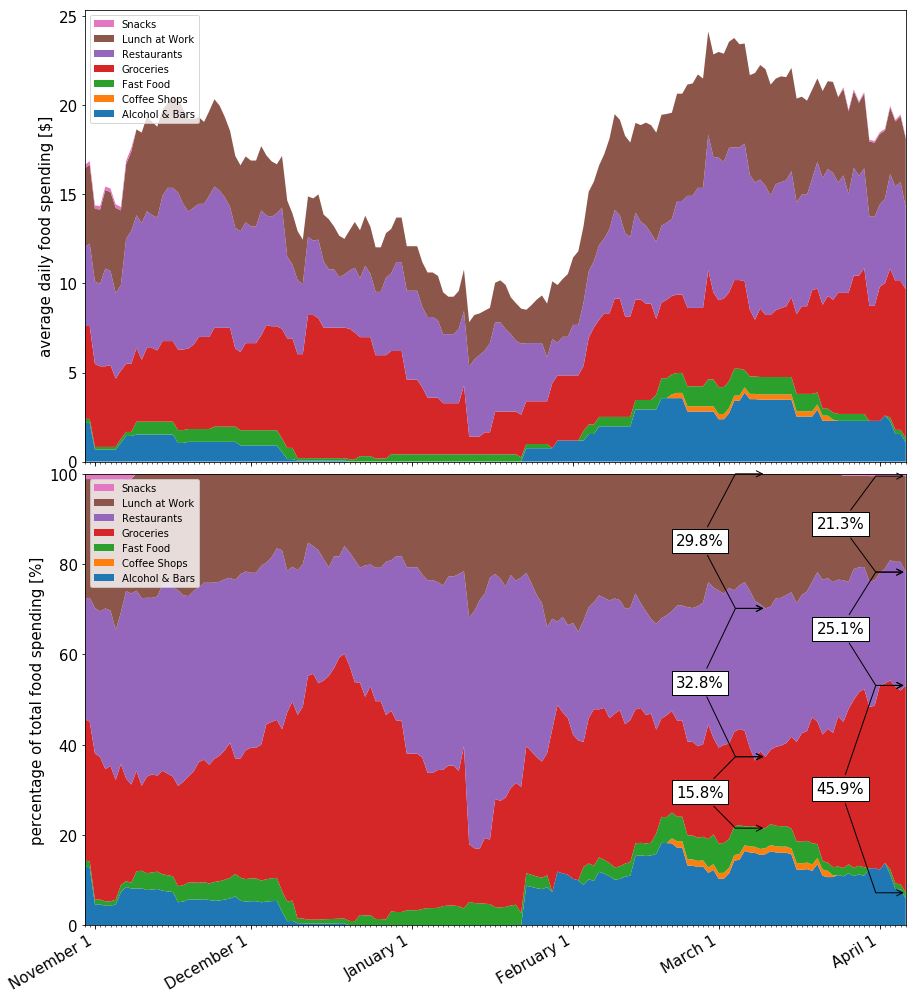

In [114]:
def add_braces(ax, text, x0, y0, x1, y1, y2):
    ax.annotate(text,
                xy=(x1,y2),
                xytext=(x0,y0),
                xycoords='data',
                ha='right',
                va='center',
                bbox=dict(boxstyle='square', fc='white'),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc, armB=-30"))
    ax.annotate(text, 
                xy=(x1,y1),
                xytext=(x0,y0),
                xycoords='data',
                ha='right',
                va='center',
                bbox=dict(boxstyle='square', fc='white'),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc, armB=-30"))

rolling_dates,rolling = calculate_rolling_window_stacked(dates, daily_sums, 30)
    
y = np.row_stack(list(zip(*rolling)))  
percent = y /  y.sum(axis=0).astype(float) * 100 

fig, (ax2, ax) = plt.subplots(2, facecolor='white', sharex=True, figsize=(12,16))
plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)
k = ax.stackplot(rolling_dates, percent)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = k[::-1], labels = food_categories[::-1], prop={'size':10}, loc=2)
ax.set_ylabel("percentage of total food spending [%]")
ax.set_xlim([rolling_dates[0],rolling_dates[-1]])
ax.set_ylim([0,100])

k = ax2.stackplot(rolling_dates, y)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles = k[::-1], labels = food_categories[::-1], prop={'size':10}, loc=2)
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthFmt)
ax2.xaxis.set_minor_locator(days)
fig.autofmt_xdate()
ax2.set_ylabel("average daily food spending [$]")


date_1 = datetime(day=10, month=3, year=2017)
date_1_index = rolling_dates.index(date_1)

accu = list(accumulate([percent[i][date_1_index] for i in range(7)]))

for i in [2,3,4]:
    add_braces(ax,"{0:.1f}%".format(accu[i+1]-accu[i]),(date_1 - timedelta(days = 8)),(accu[i+1]-accu[i])/2 + accu[i],date_1,accu[i],accu[i+1])


date_2 = rolling_dates[-1]
date_2_index = rolling_dates.index(date_2)

accu = list(accumulate([percent[i][date_2_index] for i in range(7)]))

for i in [2,3,4]:
    add_braces(ax,"{0:.1f}%".format(accu[i+1]-accu[i]),(date_2 - timedelta(days = 8)),(accu[i+1]-accu[i])/2 + accu[i],date_2,accu[i],accu[i+1])

    
plt.show()

Because I'm also interested in how my choice of average has affected the presentation, I'd like to see how the data changes if I tighten up my window.

In [ ]:
data = [calculate_rolling_window_total(t) for t in range(5, 61, 2)]

cm_subsection = np.linspace(0, 1, len(data)) 
colors = [ cm.viridis(x) for x in cm_subsection ]

fig, ax = plt.subplots(1)
for i, window in enumerate(data):
    ax.plot(window[0],window[1], color = colors[i], lw=8, label=(5*i)+5)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthFmt)
ax.xaxis.set_minor_locator(days)
fig.autofmt_xdate()
plt.ylabel("average daily food spending [$]")
ax.set_xlim([data[-1][0][0],data[0][0][-1]])
ax.set_ylim([0,40])
plt.show()

[^floating_bitcoin]: As an aside, here's a fun example of what can happen if you store currencies as floating point numbers: https://hackerone.com/reports/176461